**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Proyecto:**

**Datos de la entrega:** Jueves 21 de noviembre 2024

---

**Estudiantes:**
- Andrey Arguedas Espinoza

## • Prerequisites

### - This version is implemented in Anaconda Navigator, if you want to to run it on Google Colab make sure to have the Pro version and mount the instance
### - You need at leat 25GB RAM to run this project
### - Add the dataset to the same path you have the notebook so it loads inmediately

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Super important for these type of projects where plotting consumes a lot of resources
import random
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.editor import concatenate_videoclips

### • Define global variables for the project

In [26]:
# Path to UCF-101 dataset (replace with your path)
dataset_path = './UCF101/UCF-101/'

#Path of long untrimmed videos
long_videos_path = './untrimmed_videos/'

#Checkpoints folder
checkpoints_classification = 'checkpoints_classification'

#checkpoint filename to save
checkpoint_filename = 'detection_model{epoch:02d}.h5'
#checkpoint filename to load
checkpoint_filename_load = 'detection_model50.h5'

# Specify frame size (width, height) for resizing
frame_size = (50, 50)
# We create shifted windows of 90 frames
frames_per_video = 90
batch_size = 128
epochs = 50

### • Function to show video frames

In [3]:
# Function to visualize video frames in a multi-row grid
def visualize_video(frames, num_frames=16, num_rows=2):
    num_cols = num_frames // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    
    for i in range(num_frames):
        row = i // num_cols
        col = i % num_cols
        if i < len(frames):
            axes[row, col].imshow(frames[i])
        axes[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

### • Load the dataset and create the dataset structure
### Note: If for some reason a trimmed video from the UCF-101 is less than 3 seconds is completed with the last frame (not a very common case)

In [4]:
# Function to read video and resize frames
def load_video(video_path, frame_size=frame_size, num_frames=frames_per_video):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while len(frames) < num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()

    # If video is shorter than num_frames, repeat last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames, dtype=np.uint8)


# Function to create dataset in NumPy array format
def create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=frames_per_video, load_until=6000):
    video_data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        for video_file in os.listdir(class_dir):
            if  len(video_data) < load_until:
                video_path = os.path.join(class_dir, video_file)
                video_frames = load_video(video_path, frame_size, frames_per_video)
                video_data.append(video_frames)
                labels.append(label)
                if len(video_data) % 1000 == 0:
                    print("Amount of loaded videos: ", len(video_data))

    # Convert lists to NumPy arrays
    video_data = np.array(video_data, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)

    return video_data, labels, len(video_data), class_names

In [5]:
# Create the dataset
dataset, labels, amount_of_videos, class_names = create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=frames_per_video, load_until = 6000)

Amount of loaded videos:  1000
Amount of loaded videos:  2000
Amount of loaded videos:  3000
Amount of loaded videos:  4000
Amount of loaded videos:  5000
Amount of loaded videos:  6000


### • Choose a random video from the dataset and plot it

This video belongs to the class:  CuttingInKitchen


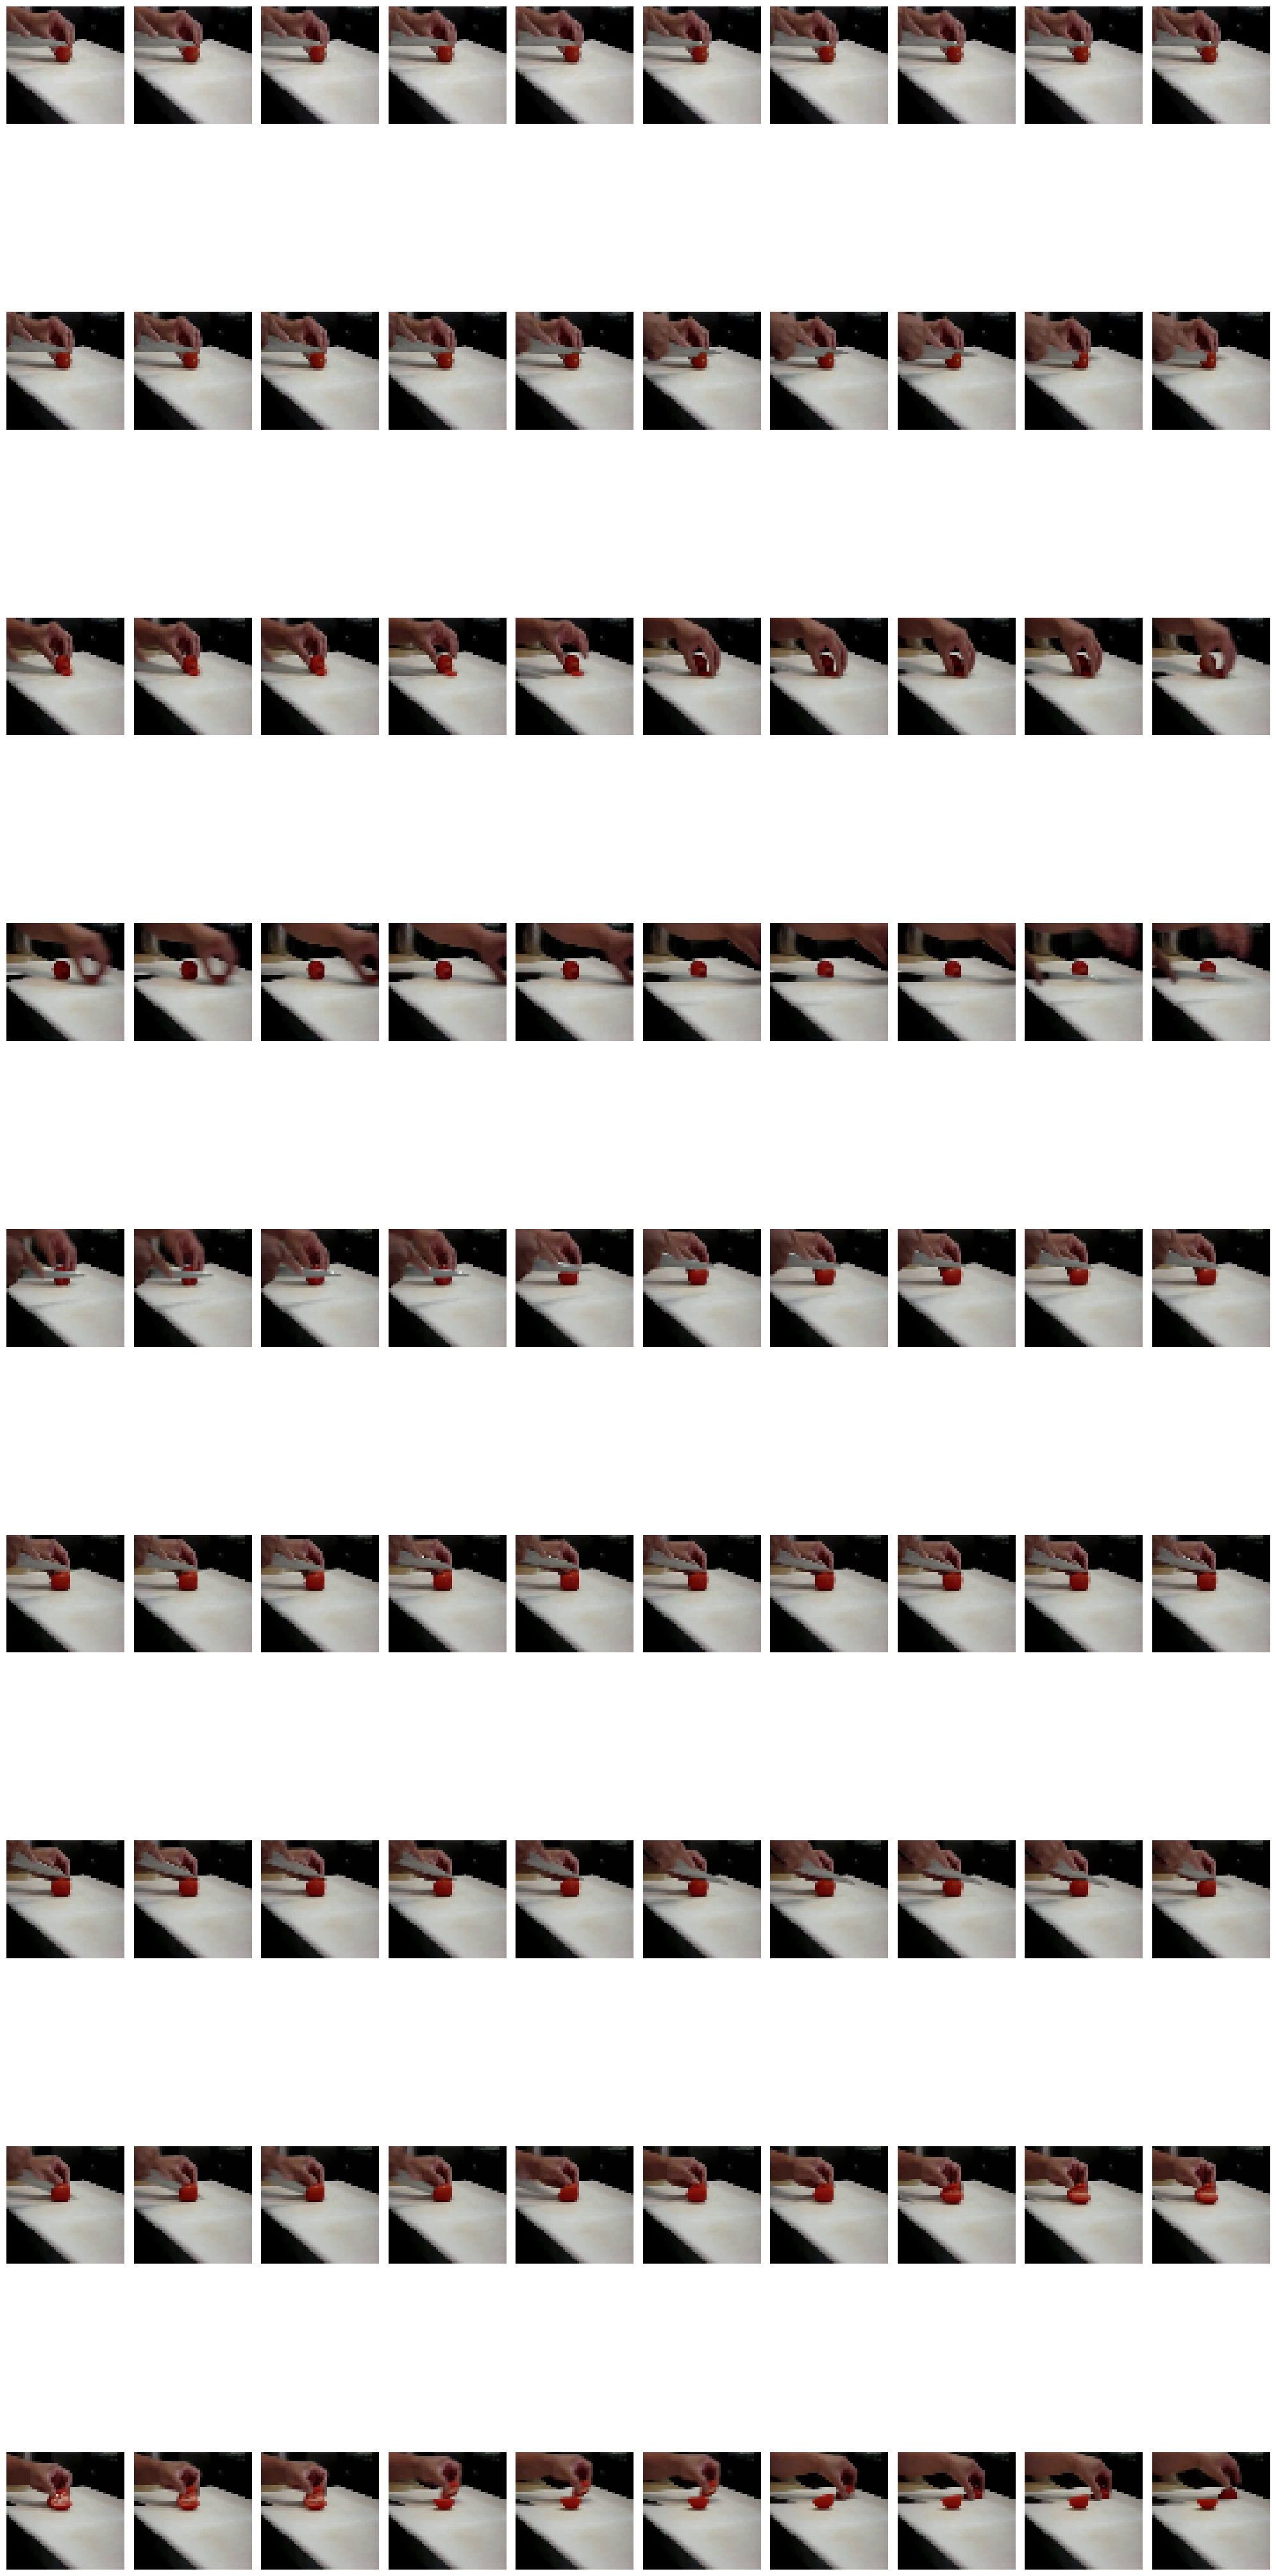

In [6]:
randomIndex = random.randint(0, dataset.shape[0] - 1)
print("This video belongs to the class: ", class_names[labels[randomIndex]])
visualize_video(dataset[randomIndex], num_frames=frames_per_video, num_rows=9)

### • Dataset split

### Important: We give a little more size to the validation partition this helped us reduced the overfitting we were having at the beggining

In [7]:
# Step 1: Split into train (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset, labels, train_size=0.7)


# Step 2: Split remaining data into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.4)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (4200, 90, 50, 50, 3)
Dimensions of training labels:  (4200,)
Dimensions of validation data:  (1080, 90, 50, 50, 3)
Dimensions of validation labels:  (1080,)
Dimensions of test data:  (720, 90, 50, 50, 3)
Dimensions of test data:  (720,)


### • Data normalization 

In [8]:
X_train_normalized = X_train.astype('float32') / 255

X_val_normalized = X_val.astype('float32') / 255

X_test_normalized = X_test.astype('float32') / 255

#One Hot Encoding
y_train = to_categorical(y_train, num_classes=101)

y_val = to_categorical(y_val, num_classes=101)

y_test = to_categorical(y_test, num_classes=101)


### Architecture for Temporal Action Detection and Action Recognition model

### •We create an Action-Detection classification model with the help of 3D Convolusional Networks for the processing of the frames, and the LSTM to respect time dependencies, this model is in charge of classify trimmed videos and help us to detect which action is happening in a untrimmed video

In [9]:
def build_action_detection_model(input_shape=(90, 60, 60, 3), num_classes=101):
    model = Sequential()

    # Reduced 3D CNN for spatio-temporal feature extraction
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten output and pass through LSTM
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False))

    # Fully connected layers with fewer units
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [10]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_action_detection_classification_model_loaded_from_disk = False

if os.path.isfile(checkpoints_classification + '/'  + checkpoint_filename_load):
    print("Loading saved classification model!!!")
    action_detection_model = tf.keras.models.load_model(checkpoints_classification + '/'  + checkpoint_filename_load)
    was_action_detection_classification_model_loaded_from_disk = True
else:
    print("Creating classification model!!!")
    action_detection_model = build_action_detection_model(input_shape=(frames_per_video, frame_size[0], frame_size[1], 3))
    
action_detection_model.summary()

Loading saved classification model!!!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 88, 48, 48, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 88, 48, 48, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 88, 24, 24, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 86, 22, 22, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 86, 22, 22, 64)   256       
 hNormalization)                                                 
                  

# *********************** Training phase *************************

### We use this common function to train all the architectures of our project, it also creates the checkpoints that we will save for each architecture

In [11]:
# Training the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, initial_epoch = 0, epochs=5, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, checkpoint_filename),
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save the model after every epoch, not just the best one
        monitor='loss',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), initial_epoch=initial_epoch, callbacks=[checkpoint_cb])
    return history

In [12]:
def visualize_metrics(history, under_lim = -1, upper_lim = 5):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

In [13]:
if was_action_detection_classification_model_loaded_from_disk is False:
    history = train_model(action_detection_model, X_train_normalized, y_train, X_val_normalized, y_val, batch_size=batch_size, epochs=epochs, checkpoint_dir=checkpoints_classification)
    visualize_metrics(history)
#else:
    #For now keep training until epoch 50
    #print("Continue with training")
    #history = train_model(action_detection_model, X_train_normalized, y_train, X_val_normalized, y_val, batch_size=batch_size, epochs=epochs, initial_epoch = 7, checkpoint_dir=checkpoints_classification)
    #visualize_metrics(history)

# *************************** Test phase ********************************

### • Here we will test our model against our test set

In [14]:
test_loss, test_acc, test_prec = action_detection_model.evaluate(X_test_normalized, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_loss)

23/23 [==============================] - 30s 1s/step - loss: 0.2149 - accuracy: 0.9486 - precision: 0.9604
Test accuracy:  0.9486111402511597
Test Precision: 0.9603960514068604
Test Loss: 0.21488767862319946


In [15]:
# Evaluación del modelo
predicted = action_detection_model.predict(X_test_normalized)

23/23 [==============================] - 29s 1s/step


### • Plot confusion matrix for each class of videos in the dataset

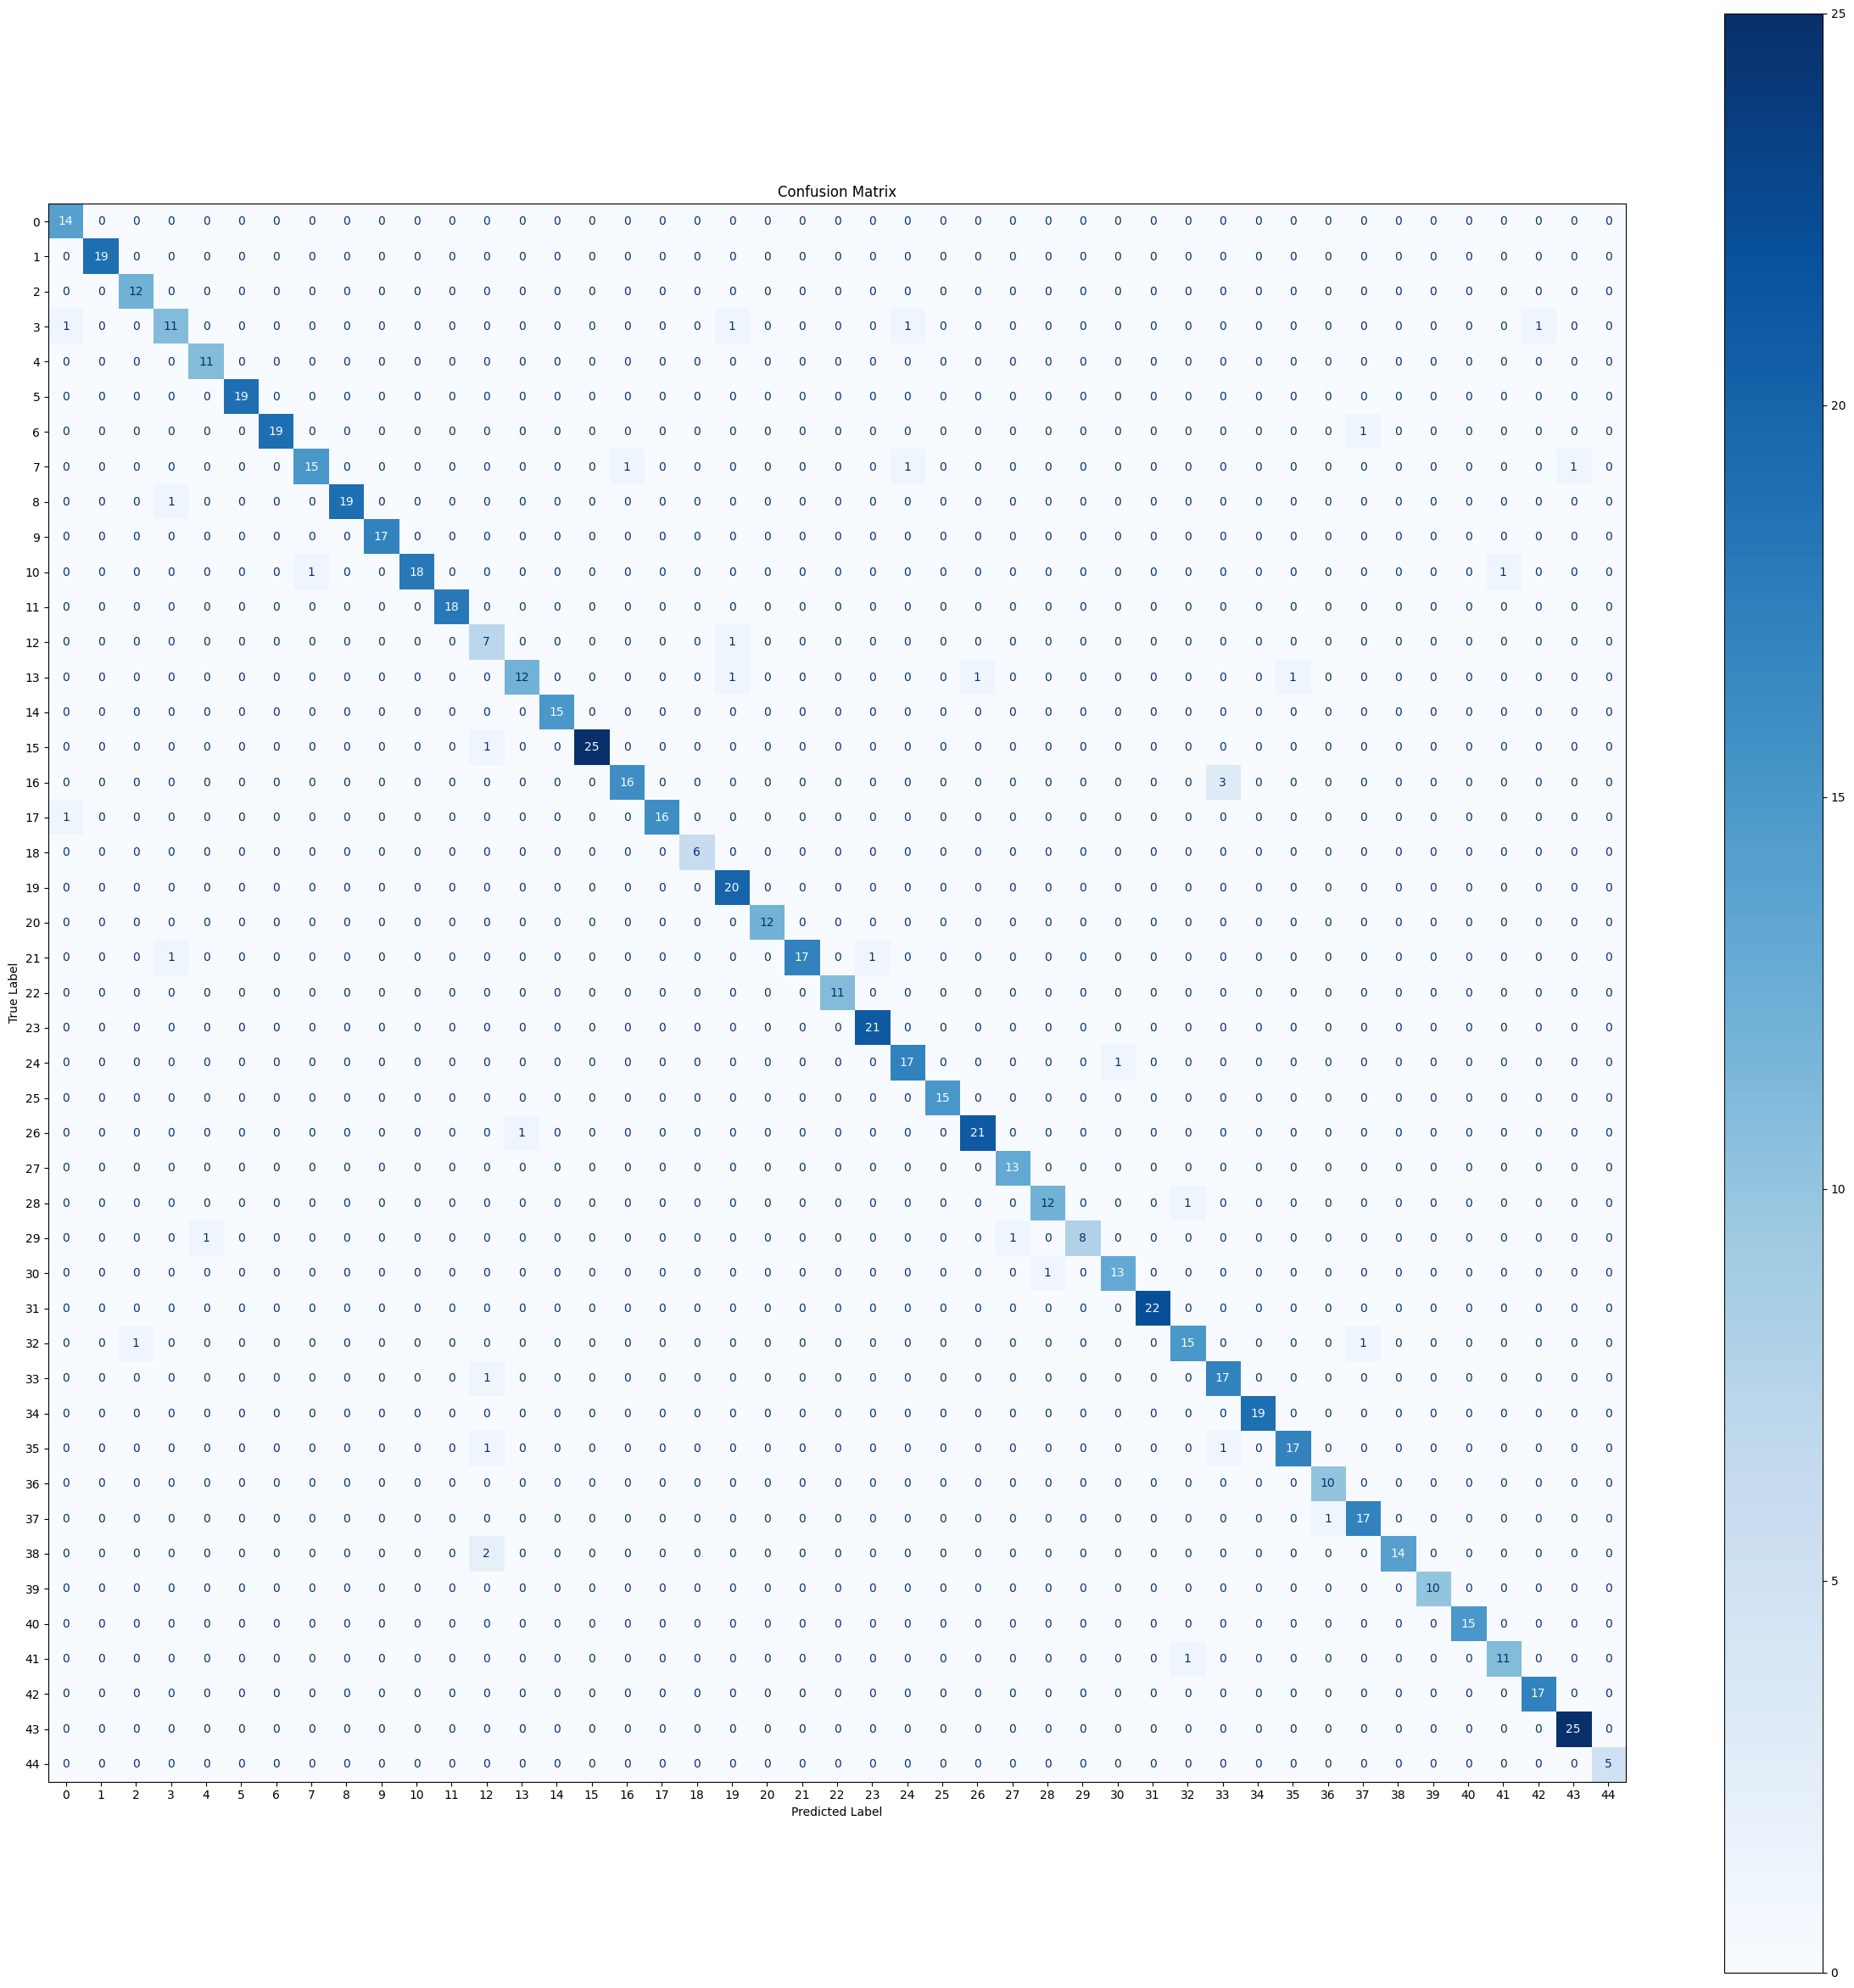

In [16]:
# Generate the confusion matrix
predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(30, 30))  # Set the figure size if needed
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### • Pick 5 random videos from test lets plot it and compare the predicted class vs the original

Predicted class:  Bowling
Original class:  Bowling


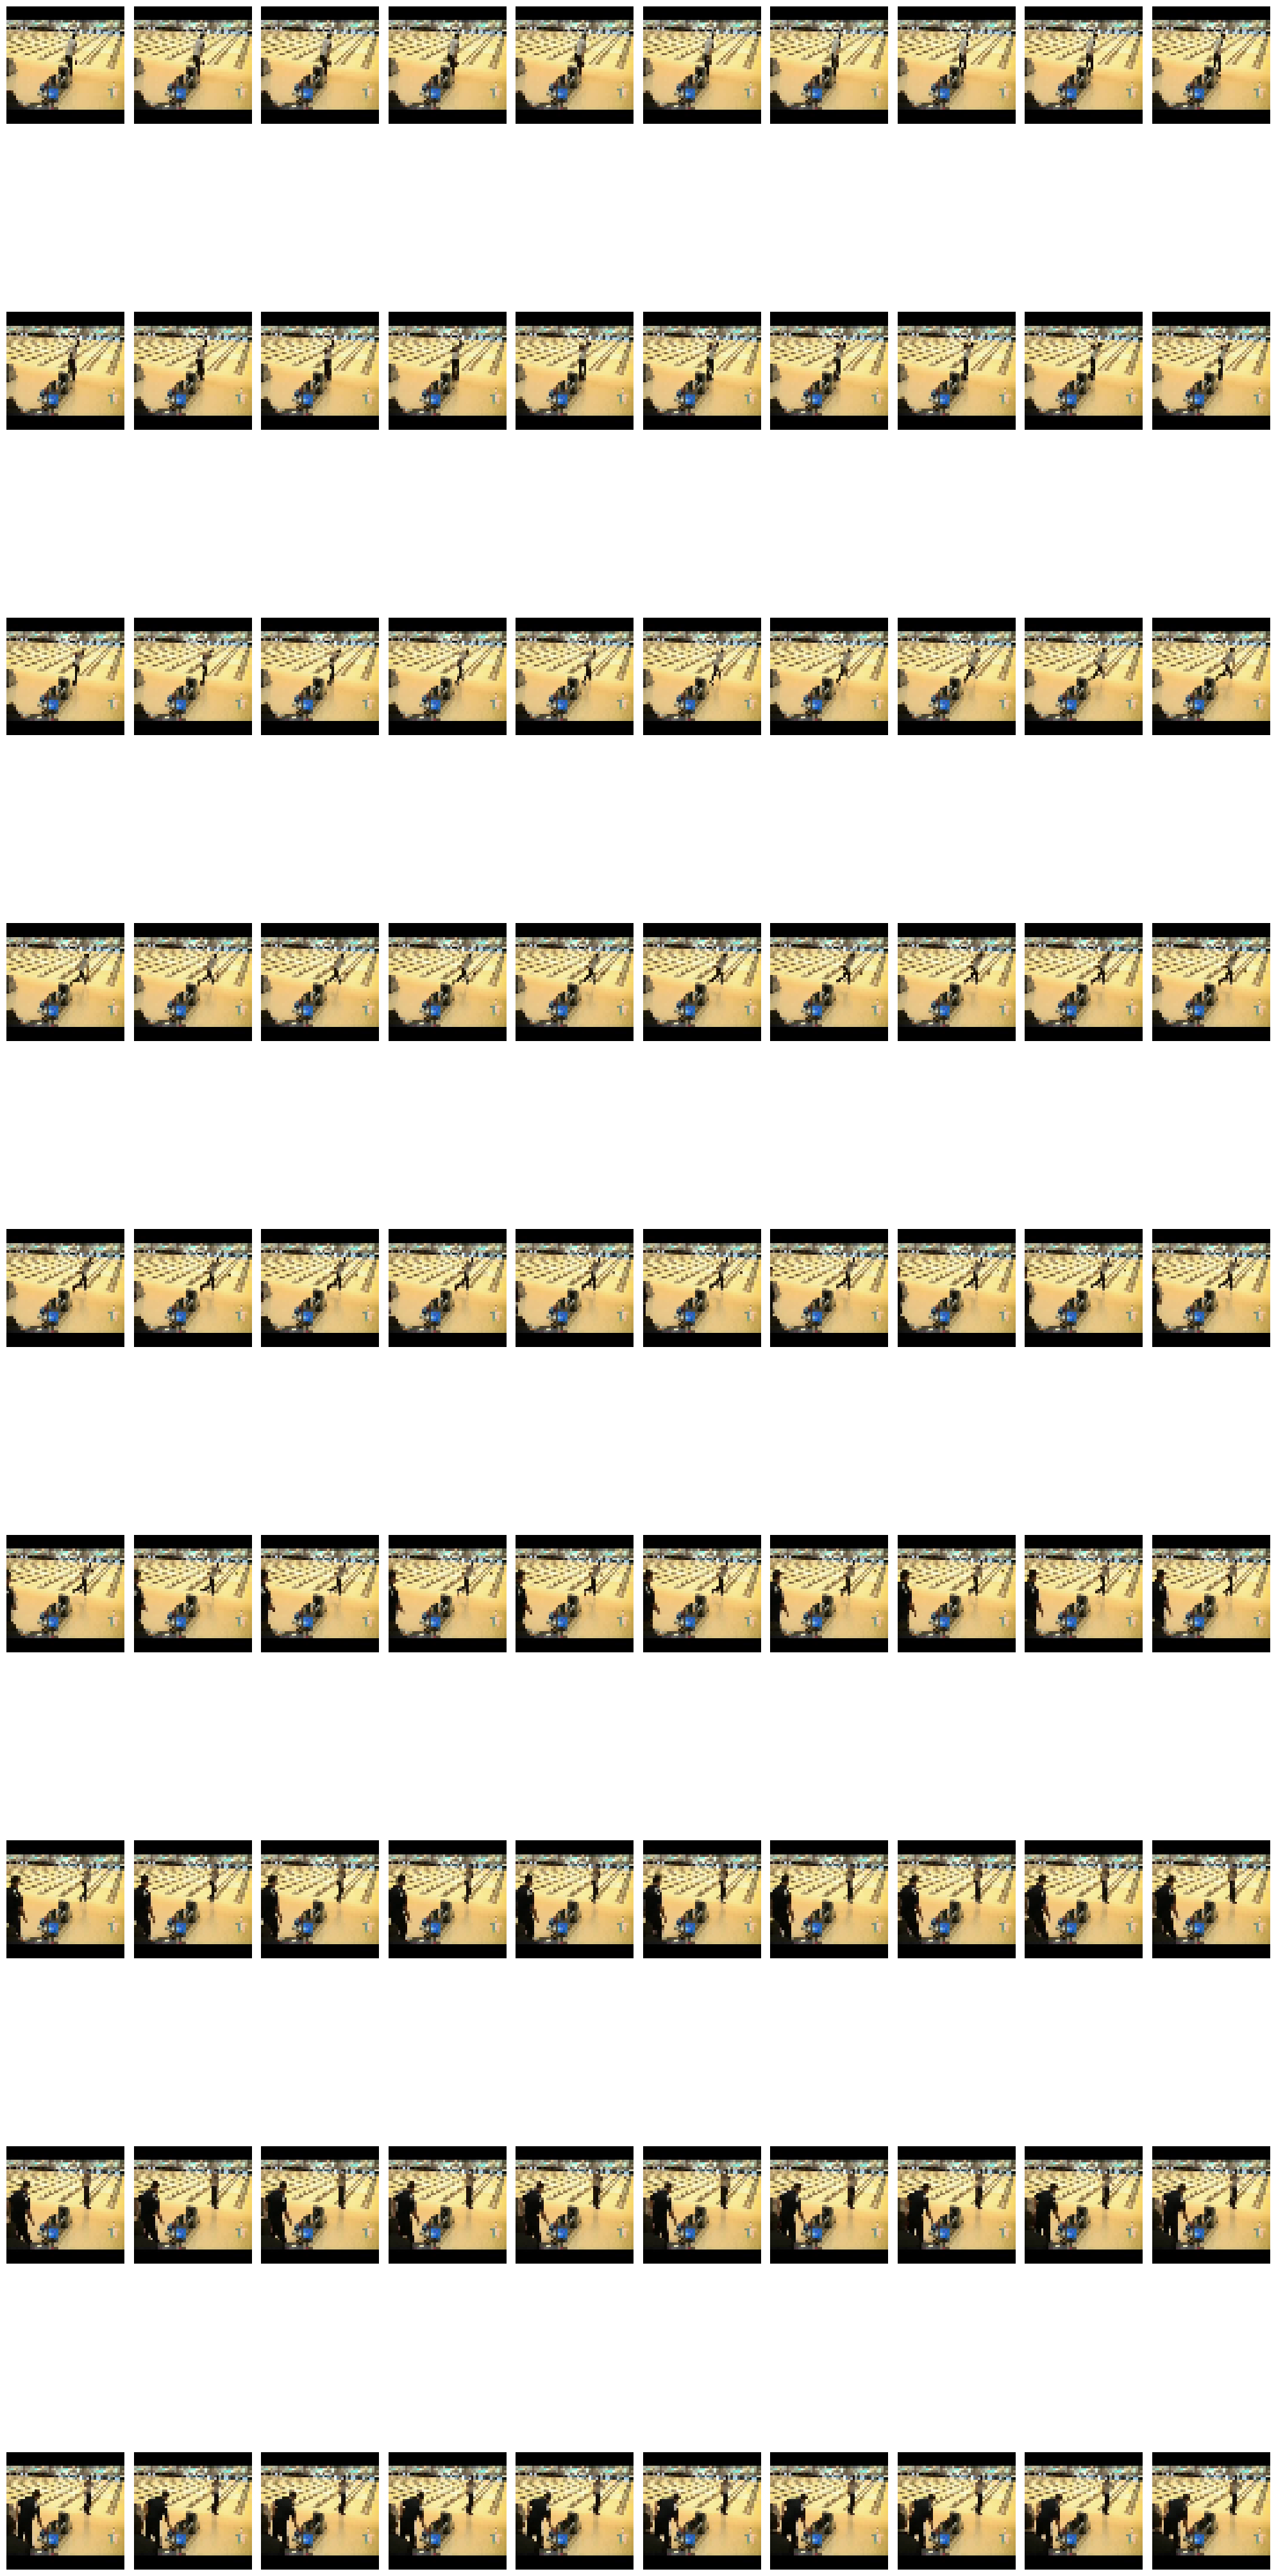

Predicted class:  BlowingCandles
Original class:  BlowingCandles


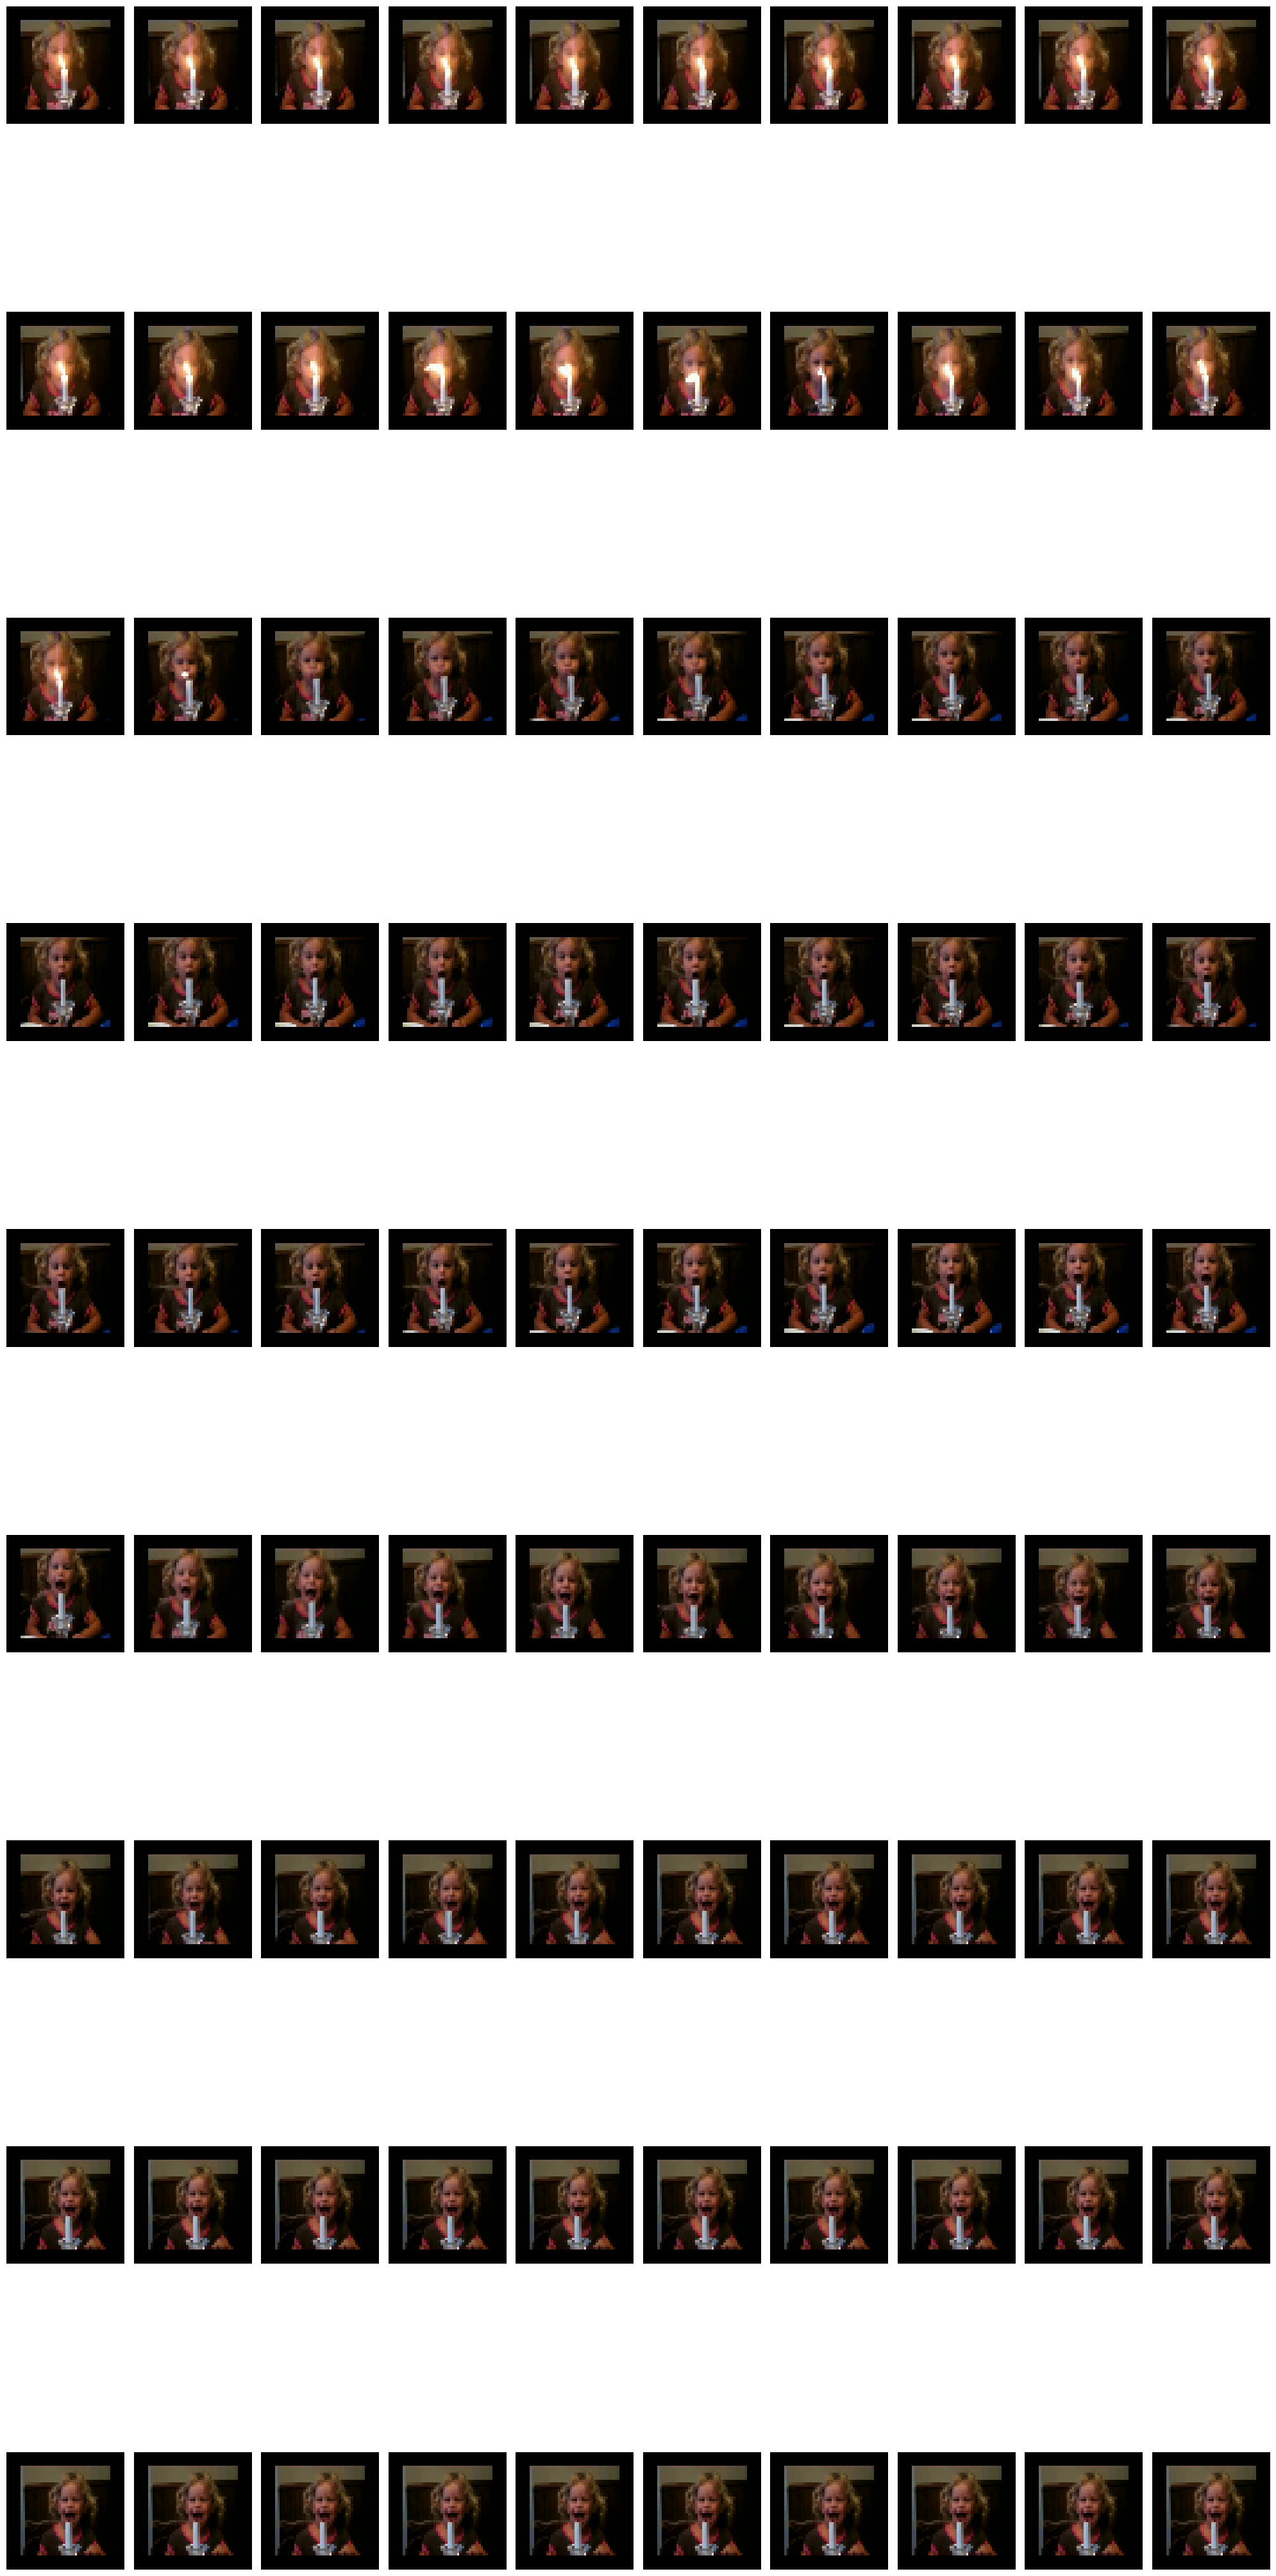

Predicted class:  ApplyLipstick
Original class:  ApplyLipstick


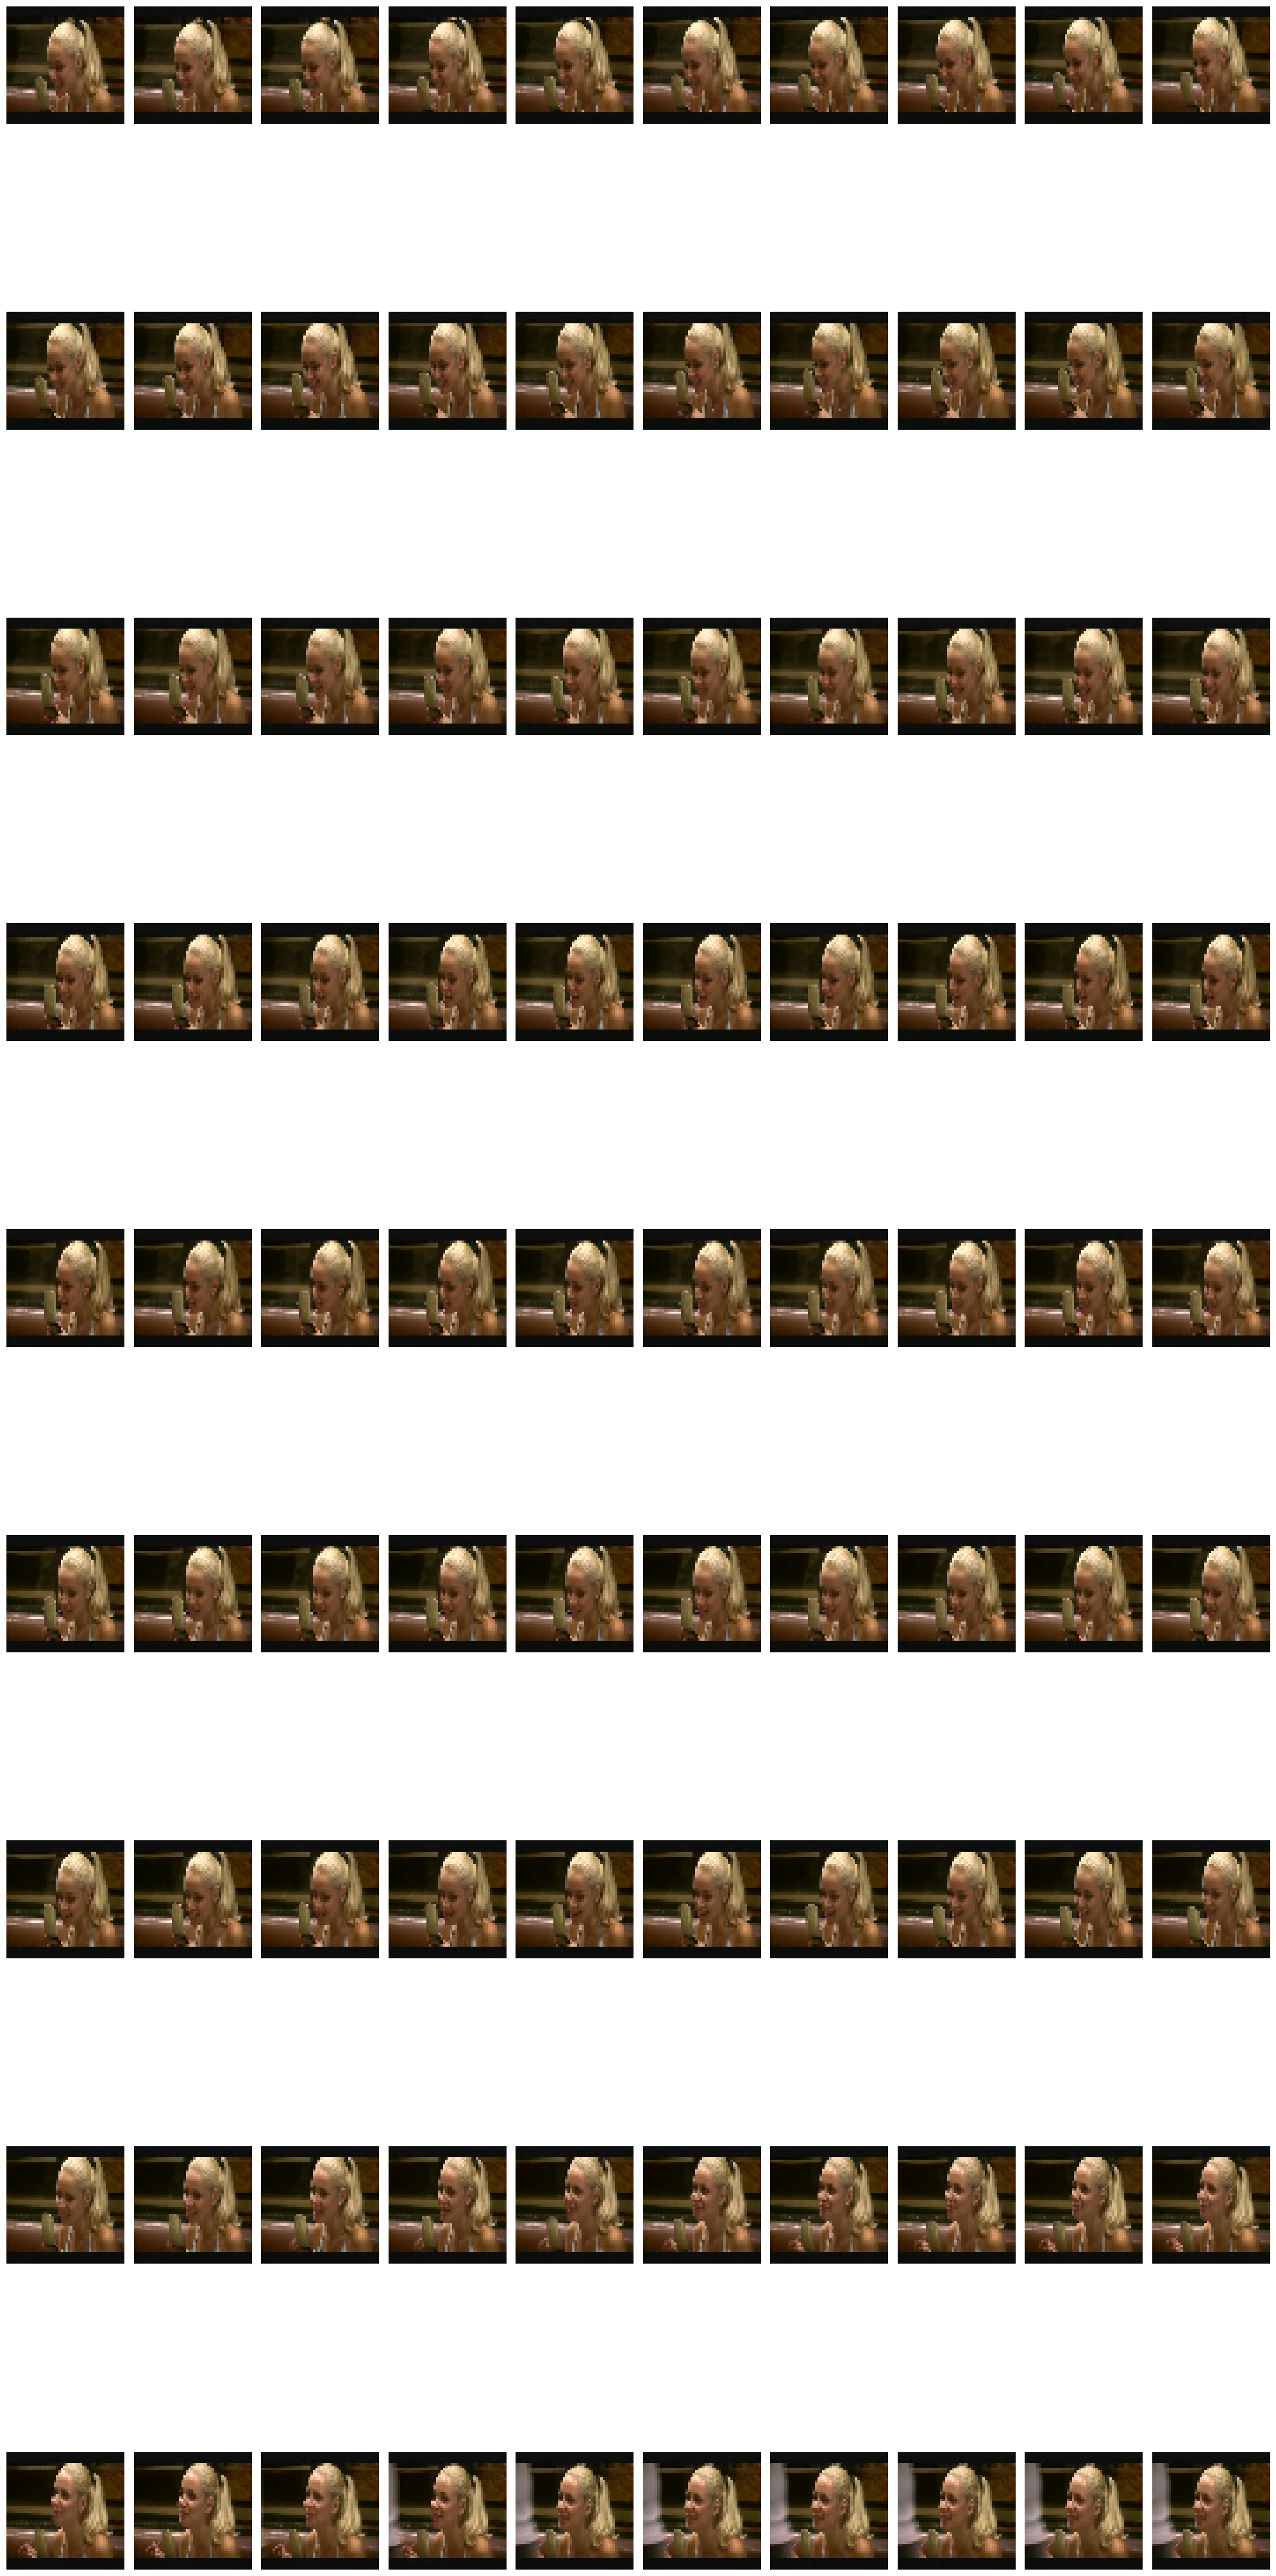

Predicted class:  CliffDiving
Original class:  CliffDiving


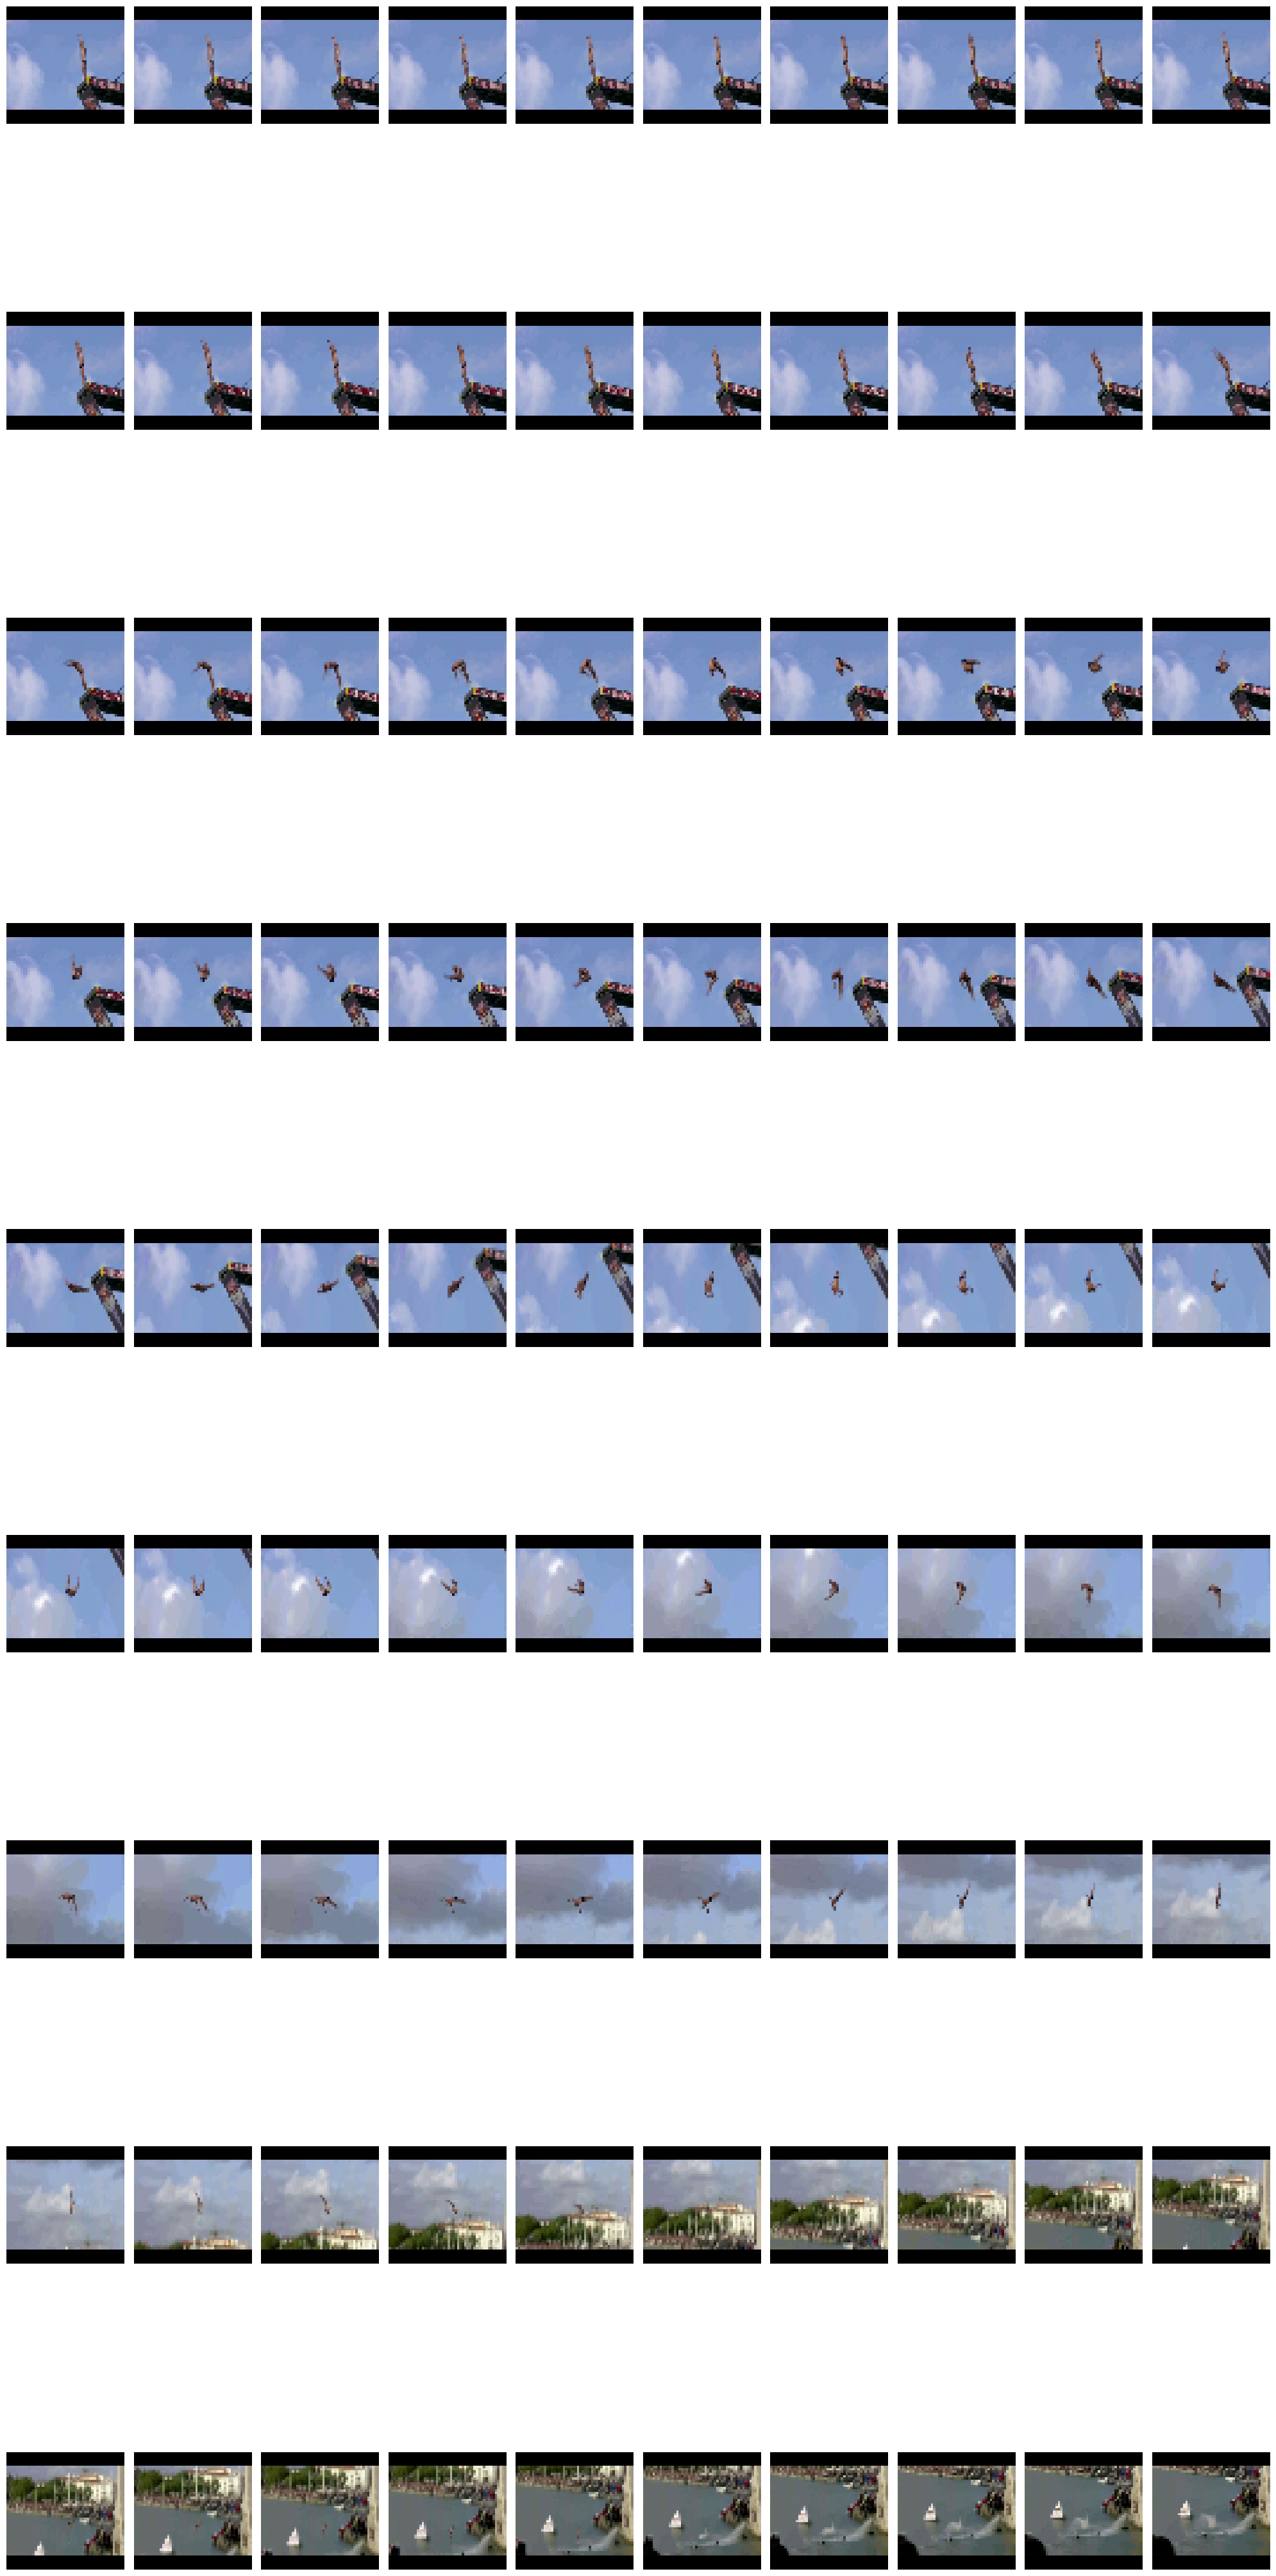

Predicted class:  HeadMassage
Original class:  HeadMassage


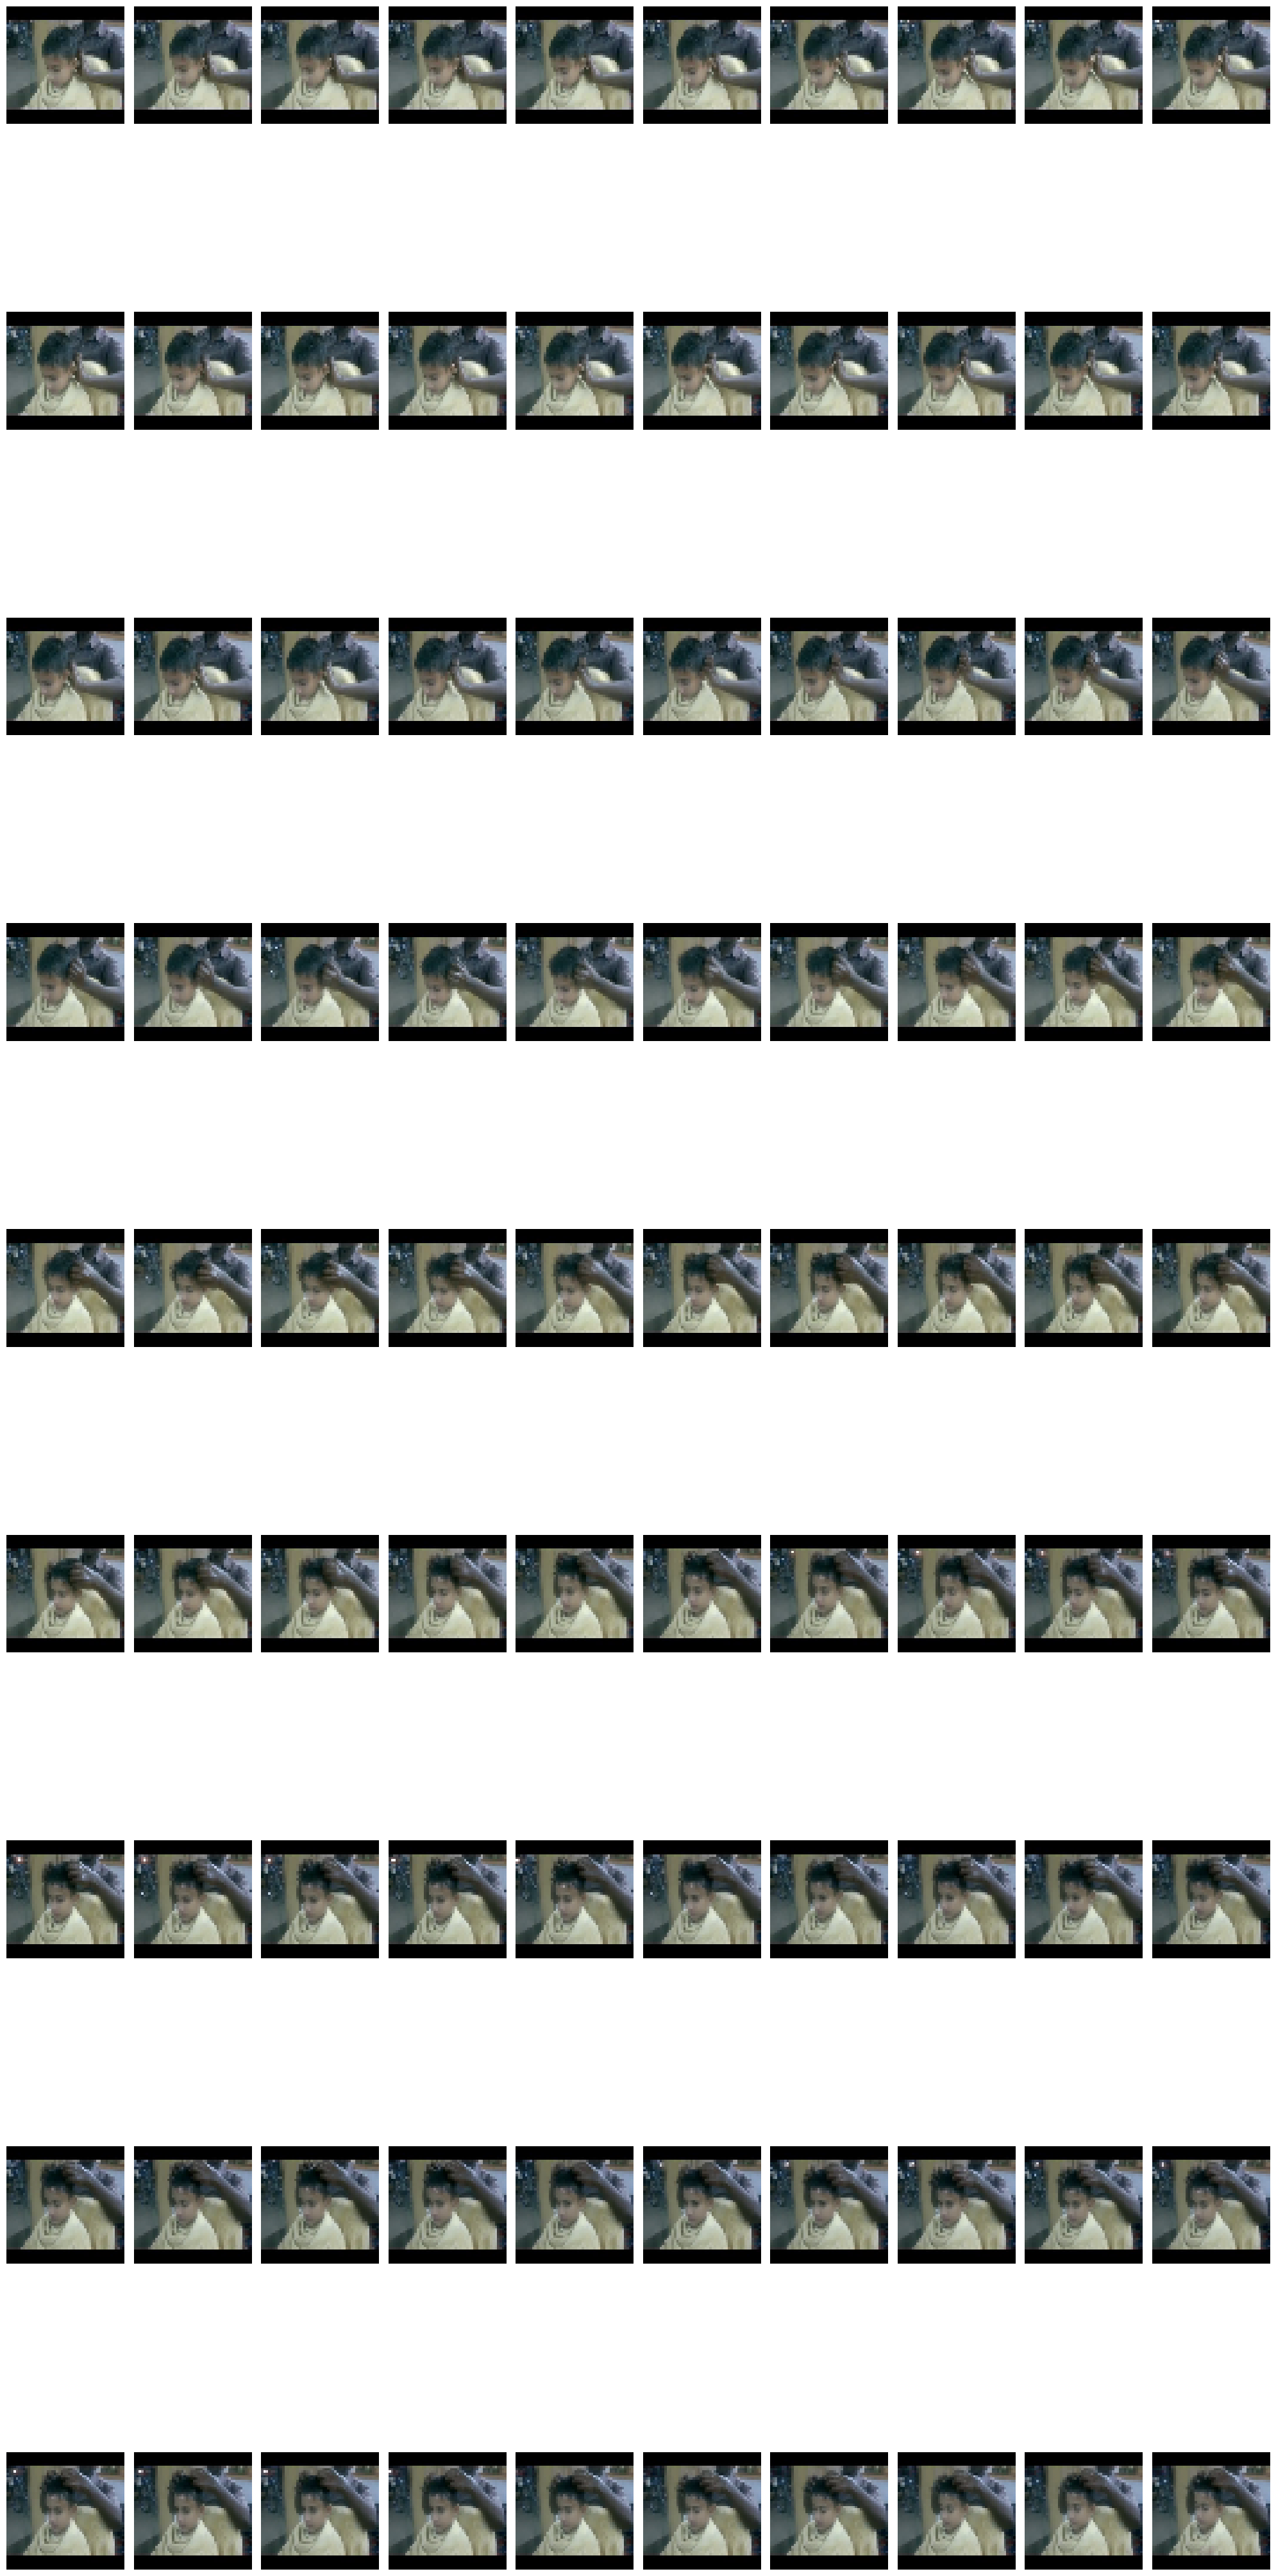

In [17]:
randomVideosIndex=[random.randint(0, len(X_test_normalized)) for x in range(5)]

for i in randomVideosIndex:
    originalVideo = X_test_normalized[i] 
    print("Predicted class: ", class_names[predicted[i]])
    print("Original class: ", class_names[y_test[i]])
    visualize_video(originalVideo, num_frames=frames_per_video, num_rows=9)

### • Create a video trimmer based on the concept of weakly supervised Temporal Action Detection and the Video Classification Model

### • Load the long videos, notice there is an special folder for long untrimmed videos only

### This videos contain a lot of footage but we want to trim only the parts that we are interested based on the model predicted classification

In [30]:
def load_complete_video(video_path, frame_size=(60, 60)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()
    
    return np.array(frames, dtype=np.uint8)

### Function to load full videos
def load_full_videos(long_videos_path, frame_size=frame_size):
    video_data = []
    labels = []
    video_names = []
    class_names = sorted(os.listdir(long_videos_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(long_videos_path, class_name)
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            video_frames = load_complete_video(video_path, frame_size)
            video_data.append(video_frames)
            labels.append(label)
            video_names.append(video_file)

    labels = np.array(labels, dtype=np.int32)

    return video_data, labels, len(video_data), class_names, video_names


In [31]:
long_videos_dataset, long_videos_labels, long_videos_amount_of_videos, long_videos_class_names, long_video_names = load_full_videos(long_videos_path, frame_size=frame_size)

In [32]:
print(long_video_names)

['video_validation_0000574.mp4', 'video_validation_0000051.mp4', 'video_validation_0000152.mp4', 'video_validation_0000673.mp4']


### • Now split the long video in windows of 3 seconds each (90 frames)

In [33]:
def splitten_videos_windows(long_videos_dataset, frames_per_video):
    sequence_of_small_videos = []
    for longVideo in long_videos_dataset:
        long_video_frames = longVideo.shape[0]
        # Determine the number of chunks and reshape accordingly
        chunk_size = frames_per_video
        num_chunks = math.floor(long_video_frames / frames_per_video)
        # Slice the first X elements and reshape into (90, 50, 50, 3)
        splittenVideo = longVideo[:num_chunks * chunk_size].reshape((num_chunks, chunk_size, frame_size[0], frame_size[1], 3))
        sequence_of_small_videos.append(splittenVideo)
    return sequence_of_small_videos


### • Generate a clip times in seconds, this is based on the TAD concept where we get an start time and end time for an specific action.

In [34]:
def generate_trim_clips_times(relevantClasses, windows_amount, class_names, predicted_small_video):
    trim_clips_video = []
    seconds_size = frames_per_video / 30
    for i in range(0, windows_amount):
        print("Predicted class: ", class_names[predicted_small_video[i]])
        if(predicted_small_video[i] in relevantClasses):
            trim_clips_video.append((seconds_size * i, seconds_size * i + seconds_size))
    return trim_clips_video

### • Common function to trim videos based on generated clip times

In [35]:
def trim_video(input_path, output_path, trim_intervals):
    """
    Trims a video to the specified intervals and combines them into a single output.

    Parameters:
    - input_path (str): Path to the input video file.
    - output_path (str): Path to save the trimmed video file.
    - trim_intervals (list of tuples): List of (start_time, end_time) tuples in seconds.
    """
    # Load the video file
    with VideoFileClip(input_path) as video:
        # Attempt to retrieve fps from the input video
        video_fps = video.fps if video.fps is not None else fps
        print(f"Using FPS: {video_fps}")

        # Create subclips based on the specified intervals
        clips = [video.subclip(start, end) for start, end in trim_intervals]

        # Concatenate all subclips into one video
        final_clip = concatenate_videoclips(clips, method="compose")
        
        # Write the result to a file with specified fps and codec
        final_clip.write_videofile(output_path, codec="libx264", fps=30)
    
    print(f"Trimmed video saved as {output_path}")

### • Relevant classes : In here we define a set of relevant classes, for example the video contains a band marching video, but this is really similar to a Military Parade and there is also Drumming parts that we would like to have in our final trimmed video so we are going to use all these for our final output

In [36]:
#Drumming, Band Marching, Military Parade
relevantClassesMarchingBand = [5, 26, 52]

#Billiards
relevantClassesBilliards = [11]

#CleanAndJerk, HandstandPushups, BodyWeightSquats
relevantClassesExercises= [20, 36, 14]

#Balance Beam, Floor Gymnastics
relevantGymnastics = [4, 29]

relevantClasses = [relevantClassesMarchingBand, relevantClassesBilliards, relevantClassesExercises, relevantGymnastics]

In [37]:
sequence_windows_splitten_videos = splitten_videos_windows(long_videos_dataset, frames_per_video)

predicted_small_videos = []
i = 0
for sequencedVideo in sequence_windows_splitten_videos:
    sequence_of_small_videos_normalized = sequencedVideo.astype('float32') / 255
    small_video_predicted = action_detection_model.predict(sequence_of_small_videos_normalized)
    predicted_small_video = np.argmax(small_video_predicted, axis=1)
    print(predicted_small_video)
    trim_intervals = generate_trim_clips_times(relevantClasses[i], len(sequencedVideo), class_names, predicted_small_video)
    print(trim_intervals)
    trim_video(long_videos_path + long_videos_class_names[long_videos_labels[i]] + "/" + long_video_names[i],"./trimmedVideos/" + long_video_names[i], trim_intervals)
    i += 1


2/2 [==============================] - 1s 583ms/step
[ 9  8  5  5  2 13  5  5  5 26 26  5  2 13  9  5  5  2  5  5  5  5 26  8
  8  9 38  8  5 12  7  5  2  2  5  5  2 17 27  5 12  7  2  5  5  5 32  5
  5  5  5  5  5  5  5]
Predicted class:  BenchPress
Predicted class:  BasketballDunk
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  Archery
Predicted class:  BlowingCandles
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  Drumming
Predicted class:  Drumming
Predicted class:  BandMarching
Predicted class:  Archery
Predicted class:  BlowingCandles
Predicted class:  BenchPress
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  Archery
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  Drumming
Predicted class:  BasketballDunk
Predicted class:  BasketballDunk
Predicted class:  BenchP

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000574.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000574.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000574.mp4
2/2 [==============================] - 2s 710ms/step
[25 25 25 25 38 19 43 31 31 11 25 11 11 25 25 25 25 25 11 25 25 25 37 11
 11 11 11 11 11 11 11  0  0 21 14 25 25 25 21 25 25 25 25 21  9 25 25 25
 25 11 21 25 25 25 25 25]
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  HeadMassage
Predicted class:  BrushingTeeth
Predicted class:  IceDancing
Predicted class:  FrontCrawl
Predicted class:  FrontCrawl
Predicted class:  Billiards
Predicted class:  Diving
Predicted class:  Billiards
Predicted class:  Billiards
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Billiards
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  Diving
Predicted class:  HandstandWalking
Pr

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000051.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000051.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000051.mp4
2/2 [==============================] - 2s 683ms/step
[37 16 38  3 36 36 16 16 16 12 38 38 19 38  2 38 38 36 36  2  2 28 16  2
 32 12 33 36  3  2  2  2 32 14 14 16  2 36  2  2 16  2 27 27 27  7  5 41
  2  2 41 38  2 27 27]
Predicted class:  HandstandWalking
Predicted class:  BoxingPunchingBag
Predicted class:  HeadMassage
Predicted class:  BabyCrawling
Predicted class:  HandstandPushups
Predicted class:  HandstandPushups
Predicted class:  BoxingPunchingBag
Predicted class:  BoxingPunchingBag
Predicted class:  BoxingPunchingBag
Predicted class:  BlowDryHair
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  BrushingTeeth
Predicted class:  HeadMassage
Predicted class:  Archery
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  HandstandPushups
Predicted class:  HandstandPushups
Predicte

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000152.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000152.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000152.mp4
2/2 [==============================] - 1s 385ms/step
[13 13 13 27  4  4  4  4  4  4 15  7  4  8  4 26 26  4 26 17 34 17 13 27
  5 26 26 26  1 27 26 27 26 26 42  1 13 26 26 26 13 33 33 33]
Predicted class:  BlowingCandles
Predicted class:  BlowingCandles
Predicted class:  BlowingCandles
Predicted class:  Fencing
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  Bowling
Predicted class:  Basketball
Predicted class:  BalanceBeam
Predicted class:  BasketballDunk
Predicted class:  BalanceBeam
Predicted class:  Drumming
Predicted class:  Drumming
Predicted class:  BalanceBeam
Predicted class:  Drumming
Predicted class:  BoxingSpeedBag
Predicted class:  HammerThrow
Predicted class:  BoxingSpeedBag


MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000673.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000673.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000673.mp4
